<a href="https://colab.research.google.com/github/ethanchoi1116/probabilistic-deep-learning/blob/main/notebooks/heteroskedastic_nonlinear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heteroskedastic Nonlinear Regression using `TensorFlow Probability`
---

## Import Necessary Libraries

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm.keras import TqdmCallback
import matplotlib.pyplot as plt
import seaborn as sns
tfd= tfp.distributions

## Simulated Data

In [2]:
# 1d input
n = 2000
x = np.linspace(0, 1, n)

In [3]:
# mean function mu(x)
def mu(x):
    # function for simulating mean structure
    # x in [0,1] ; sorted
    return np.sin(10*x)

In [4]:
# std dev function s(x)
def s(x):
    # function for simulating variance structure
    # x in [0,1] ; sorted
    return np.sqrt(np.exp(2*np.cos(10*x)))

In [5]:
# sample from heteroskedastic 1d normal distribution
dist = tfp.layers.DistributionLambda(lambda x: tfd.Normal(loc=mu(x), scale=s(x)))(x)
y = tf.squeeze(dist.sample(1)).numpy()

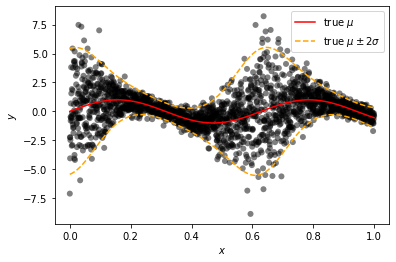

In [6]:
# simulated data
sns.scatterplot(x=x, y=y, color="black", alpha=0.5, edgecolor="none")
sns.lineplot(x=x, y=mu(x), color="red", label="true $\mu$")
sns.lineplot(x=x, y=mu(x)+2*s(x), color="orange", linestyle="dashed", label="true $\mu\pm2\sigma$")
sns.lineplot(x=x, y=mu(x)-2*s(x), color="orange", linestyle="dashed")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()

In [7]:
# train val test split
X_train, X_test, y_train, y_test = train_test_split(x.reshape(-1,1), y, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [8]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1440, 1), (360, 1), (200, 1), (1440,), (360,), (200,))

## Writing a Probabilistic Model for dataset using `TFP`

In [9]:
class HetRegNet(Model):
    # model class for modeling heteroskedastic conditional normal
    def __init__(self):
        super().__init__()
        tf.keras.backend.clear_session()
        self.h = Dense(64, activation="relu")
        self.h_mu_1 = Dense(32, activation="relu")
        self.h_mu_2 = Dense(16, activation="relu")
        self.h_mu_3 = Dense(8, activation="relu")
        self.h_s2_1 = Dense(32, activation="relu")
        self.h_s2_2 = Dense(16, activation="relu")
        self.h_s2_3 = Dense(8, activation="relu")
        self.mu = Dense(1)
        self.s2 = Dense(1, activation="exponential")
        self.concat = Concatenate()
        self.dist = tfp.layers.DistributionLambda(
            lambda params: tfd.Normal(loc=params[...,0:1], scale=params[...,1:2])
        )
    
    def call(self, x):
        h = self.h(x)
        h_mu = self.h_mu_1(h)
        h_mu = self.h_mu_2(h_mu)
        h_mu = self.h_mu_3(h_mu)
        h_s2 = self.h_s2_1(h)
        h_s2 = self.h_s2_2(h_s2)
        h_s2 = self.h_s2_3(h_s2)
        mu = self.mu(h_mu)
        s2 = self.s2(h_s2)
        params = self.concat([mu, s2])
        dist = self.dist(params)
        
        return dist

def NLL(y, dist):
    # loss as a negative log likelihood given observation
    return -dist.log_prob(y)

In [10]:
# compiling model
model = HetRegNet()
model.build(input_shape=(None, 1))
model.compile(optimizer=Adam(learning_rate=0.01), loss=NLL)
model.summary()

Model: "het_reg_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  128       
_________________________________________________________________
dense_1 (Dense)              multiple                  2080      
_________________________________________________________________
dense_2 (Dense)              multiple                  528       
_________________________________________________________________
dense_3 (Dense)              multiple                  136       
_________________________________________________________________
dense_4 (Dense)              multiple                  2080      
_________________________________________________________________
dense_5 (Dense)              multiple                  528       
_________________________________________________________________
dense_6 (Dense)              multiple                  

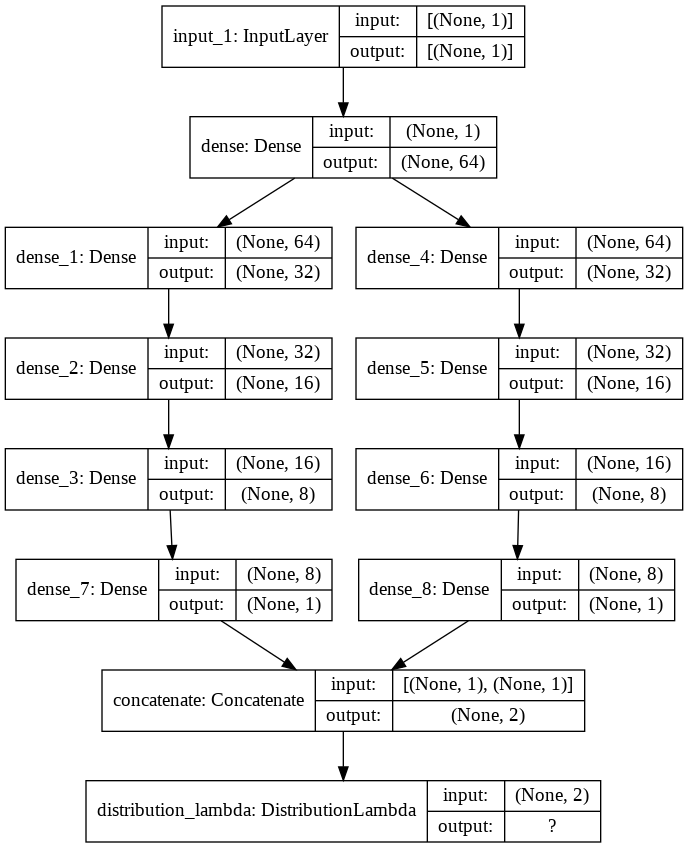

In [11]:
# visualization of model architecture
def build_graph(model):
    x = Input(shape=(1, ))
    
    return Model(inputs=[x], outputs=model.call(x))

tf.keras.utils.plot_model(build_graph(model), "model.png", show_shapes=True)

In [12]:
history = model.fit(X_train, y_train, epochs=100, verbose=0, validation_data=(X_val,y_val), callbacks=[TqdmCallback(verbose=0)])

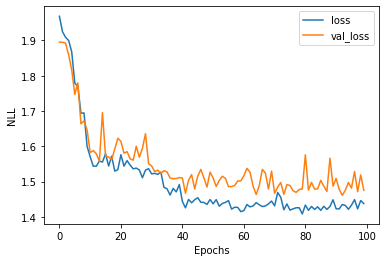

In [13]:
# loss trajectory
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.ylabel("NLL")
plt.xlabel("Epochs")
plt.show()

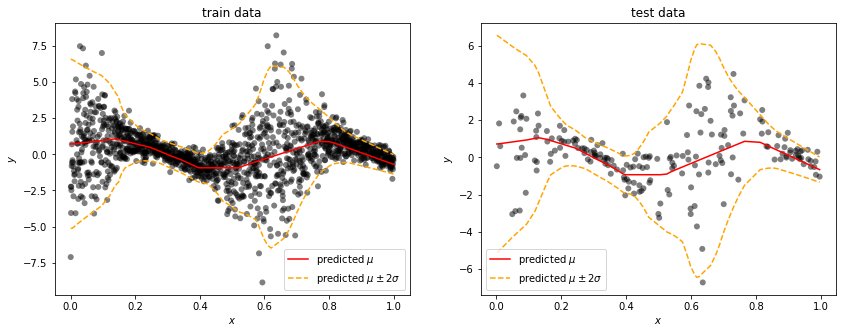

In [14]:
# prediction evaluation
mu_pred_train = model(X_train).mean().numpy().flatten()
sigma_pred_train = model(X_train).stddev().numpy().flatten()
mu_pred_test = model(X_test).mean().numpy().flatten()
sigma_pred_test = model(X_test).stddev().numpy().flatten()
# train data
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_train.flatten(), y=y_train, color="black", alpha=0.5, edgecolor="none")
sns.lineplot(x=X_train.flatten(), y=mu_pred_train, color="red", label="predicted $\mu$")
sns.lineplot(x=X_train.flatten(), y=mu_pred_train+2*sigma_pred_train, color="orange", linestyle="dashed", label="predicted $\mu\pm2\sigma$")
sns.lineplot(x=X_train.flatten(), y=mu_pred_train-2*sigma_pred_train, color="orange", linestyle="dashed")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.title("train data")
# test data
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_test.flatten(), y=y_test, color="black", alpha=0.5, edgecolor="none")
sns.lineplot(x=X_test.flatten(), y=mu_pred_test, color="red", label="predicted $\mu$")
sns.lineplot(x=X_test.flatten(), y=mu_pred_test+2*sigma_pred_test, color="orange", linestyle="dashed", label="predicted $\mu\pm2\sigma$")
sns.lineplot(x=X_test.flatten(), y=mu_pred_test-2*sigma_pred_test, color="orange", linestyle="dashed")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.title("test data")
plt.show()

## Prediction outside the observed $x$ range

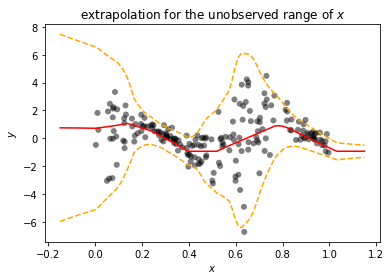

In [15]:
sns.scatterplot(x=X_test.flatten(), y=y_test, color="black", alpha=0.5, edgecolor="none")
X_new = np.linspace(-0.15, 1.15, num=100).reshape(-1,1)
mu_pred_new = model(X_new).mean().numpy().flatten()
sigma_pred_new = model(X_new).stddev().numpy().flatten()
sns.lineplot(x=X_new.flatten(), y=mu_pred_new, color="red")
sns.lineplot(x=X_new.flatten(), y=mu_pred_new+2*sigma_pred_new, color="orange", linestyle="dashed")
sns.lineplot(x=X_new.flatten(), y=mu_pred_new-2*sigma_pred_new, color="orange", linestyle="dashed")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("extrapolation for the unobserved range of $x$")
plt.show()